# Convergencia de grilla

In [4]:
# Instala librerías necesarias
!pip install torch

In [5]:
# Importa librerias necesarias
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d

import torch
import torch.nn as nn
import torch.optim as optim
from scipy.interpolate import interp2d
from scipy.interpolate import griddata

## Grilla de 5x5 (25 puntos)

Solución Exacta

In [6]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 5x5 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 5)
y = np.linspace(0, 1, 5)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_5x5 = u(X, Y)

# Interpolación para una grilla fina
x_fine = np.linspace(0, 1, 1000)
y_fine = np.linspace(0, 1, 1000)
interpolator = interp2d(x, y, u_SE_5x5.T, kind='cubic')
u_fine_SE_5x5 = interpolator(x_fine, y_fine)

del x, y, X, Y, x_fine, y_fine, interpolator

<ipython-input-6-ff3bf3f13b9b>:16: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolator = interp2d(x, y, u_SE_5x5.T, kind='cubic')
<ipython-input-6-ff3bf3f13b9b>:17: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or


Diferencias Finitas

In [7]:
# Parámetros del problema
Lx, Ly = 1.0, 1.0   # Longitud en las direcciones x e y
nx, ny = 5, 5       # Número de puntos en cada dirección
dx = Lx / (nx - 1)  # Espaciado en x
dy = Ly / (ny - 1)  # Espaciado en y

# Crea la grilla
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)

# Inicializa la matriz u (solución) y la div_u (EDP)
u = np.zeros((nx, ny))
div_u = np.sin(np.pi * x[:, None]) * np.sin(np.pi * y[None, :])

# Establece condiciones de borde de Dirichlet
u[:, 0] = 0    # u(x, 0) = 0
u[:, -1] = 0   # u(x, 1) = 0
u[0, :] = 0    # u(0, y) = 0
u[-1, :] = 0   # u(1, y) = 0

# Parámetros para el método iterativo
tolerance = 1e-12
max_iterations = 10000

# Método de diferencias finitas para la ecuación de Poisson
def poisson_solver(u, f, dx, dy, tolerance, max_iterations):
    for it in range(max_iterations):
        u_old = u.copy()
        for i in range(1, nx - 1):
            for j in range(1, ny - 1):
                u[i, j] = 0.25 * (
                    u[i+1, j] + u[i-1, j] +
                    u[i, j+1] + u[i, j-1] -
                    dx**2 * f[i, j]
                )
        # Condición de convergencia
        if np.linalg.norm(u - u_old) < tolerance:
            print(f"Converge luego de {it+1} iteraticiones")
            break
    return u

# Resuelve la ecuación de Poisson
u_DF_5x5 = poisson_solver(u, div_u, dx, dy, tolerance, max_iterations)

# Interpolación para una grilla fina
x_fine = np.linspace(0, Lx, 1000)
y_fine = np.linspace(0, Ly, 1000)
interpolator = interp2d(x, y, u_DF_5x5.T, kind='cubic')
u_fine_DF_5x5 = interpolator(x_fine, y_fine)

# Borra la solución para poder ser usada en los siguientes experimentos
del Lx, Ly, nx, ny, dx, dy, x, y, u, div_u, tolerance, max_iterations, x_fine, y_fine, interpolator

Converge luego de 38 iteraticiones


<ipython-input-7-2438fd811f65>:48: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolator = interp2d(x, y, u_DF_5x5.T, kind='cubic')
<ipython-input-7-2438fd811f65>:49: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or


PINN [2, 3, 3, 1]

In [8]:
# Define la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 3)  # Entrada
        self.fc2 = nn.Linear(3, 3)  # Capa oculta 1
        self.fc3 = nn.Linear(3, 1)  # Salida

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatena x y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Define la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, x, y, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacena los valores de la pérdida cada 100 épocas
        if epoch % 100 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializa la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define la malla 5x5 fuera del entrenamiento
x = torch.linspace(0.0, 1.0, 5).reshape(-1, 1).requires_grad_()
y = torch.linspace(0.0, 1.0, 5).reshape(-1, 1).requires_grad_()
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Entrena el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer, x, y)

# Evalua el modelo en la malla definida
u_pred_5x5_2331 = trained_model(x, y).detach().numpy()
u_pred_5x5_2331 = u_pred_5x5_2331.reshape(5, 5)

# Convierte x e y a numpy para que coincidan con la forma de u_pred
x_5x5 = x.reshape(5, 5).detach().numpy()
y_5x5 = y.reshape(5, 5).detach().numpy()

# Interpola los resultados en una grilla fina
x_fino = np.linspace(0.0, 1.0, 1000)
y_fino = np.linspace(0.0, 1.0, 1000)
X_fino, Y_fino = np.meshgrid(x_fino, y_fino)

# Aplanar datos de entrada
points = np.vstack((x_5x5.flatten(), y_5x5.flatten())).T
values = u_pred_5x5_2331.flatten()

# Interpolación
u_pred_fino_5x5_2331 = griddata(points, values, (X_fino, Y_fino), method='cubic')

del x, y, model, optimizer, trained_model, loss_physics_list, loss_boundary_list, total_loss_list, x_5x5, y_5x5, x_fino, y_fino, X_fino, Y_fino, points, values

Epoch 0, Loss: 0.6199958920478821
Epoch 100, Loss: 0.28817394375801086
Epoch 200, Loss: 0.18638494610786438
Epoch 300, Loss: 0.1664525717496872
Epoch 400, Loss: 0.15924939513206482
Epoch 500, Loss: 0.1505535989999771
Epoch 600, Loss: 0.1271190643310547
Epoch 700, Loss: 0.0970529094338417
Epoch 800, Loss: 0.09034053236246109
Epoch 900, Loss: 0.08679093420505524
Epoch 1000, Loss: 0.0830157995223999
Epoch 1100, Loss: 0.07919642329216003
Epoch 1200, Loss: 0.07576451450586319
Epoch 1300, Loss: 0.07321733236312866
Epoch 1400, Loss: 0.0717618390917778
Epoch 1500, Loss: 0.0711408406496048
Epoch 1600, Loss: 0.07092738151550293
Epoch 1700, Loss: 0.07084821909666061
Epoch 1800, Loss: 0.07080233097076416
Epoch 1900, Loss: 0.07076413929462433
Epoch 2000, Loss: 0.07072851806879044
Epoch 2100, Loss: 0.07069437205791473
Epoch 2200, Loss: 0.07066121697425842
Epoch 2300, Loss: 0.07062871009111404
Epoch 2400, Loss: 0.07059647887945175
Epoch 2500, Loss: 0.07056418806314468
Epoch 2600, Loss: 0.070531487464

PINN [2, 5, 5, 1]

In [9]:
# Define la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 5)  # Entrada
        self.fc2 = nn.Linear(5, 5)  # Capa oculta 1
        self.fc3 = nn.Linear(5, 1)  # Salida

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatena x y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Define la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, x, y, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacena los valores de la pérdida cada 100 épocas
        if epoch % 100 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializa la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define la malla 5x5 fuera del entrenamiento
x = torch.linspace(0.0, 1.0, 5).reshape(-1, 1).requires_grad_()
y = torch.linspace(0.0, 1.0, 5).reshape(-1, 1).requires_grad_()
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Entrena el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer, x, y)

# Evalua el modelo en la malla definida
u_pred_5x5_2551 = trained_model(x, y).detach().numpy()
u_pred_5x5_2551 = u_pred_5x5_2551.reshape(5, 5)

# Convierte x e y a numpy para que coincidan con la forma de u_pred
x_5x5 = x.reshape(5, 5).detach().numpy()
y_5x5 = y.reshape(5, 5).detach().numpy()

# Interpola los resultados en una grilla fina
x_fino = np.linspace(0.0, 1.0, 1000)
y_fino = np.linspace(0.0, 1.0, 1000)
X_fino, Y_fino = np.meshgrid(x_fino, y_fino)

# Aplanar datos de entrada
points = np.vstack((x_5x5.flatten(), y_5x5.flatten())).T
values = u_pred_5x5_2551.flatten()

# Interpolación
u_pred_fino_5x5_2551 = griddata(points, values, (X_fino, Y_fino), method='cubic')

del x, y, model, optimizer, trained_model, loss_physics_list, loss_boundary_list, total_loss_list, x_5x5, y_5x5, x_fino, y_fino, X_fino, Y_fino, points, values

Epoch 0, Loss: 0.23388366401195526
Epoch 100, Loss: 0.1120544895529747
Epoch 200, Loss: 0.07942794263362885
Epoch 300, Loss: 0.07165808230638504
Epoch 400, Loss: 0.06773477047681808
Epoch 500, Loss: 0.06228584796190262
Epoch 600, Loss: 0.04129733145236969
Epoch 700, Loss: 0.015952862799167633
Epoch 800, Loss: 0.011569906957447529
Epoch 900, Loss: 0.008484723046422005
Epoch 1000, Loss: 0.006728107575327158
Epoch 1100, Loss: 0.005777135491371155
Epoch 1200, Loss: 0.005157296545803547
Epoch 1300, Loss: 0.0046402206644415855
Epoch 1400, Loss: 0.0041304780170321465
Epoch 1500, Loss: 0.0036192245315760374
Epoch 1600, Loss: 0.003139350563287735
Epoch 1700, Loss: 0.002724881051108241
Epoch 1800, Loss: 0.0023825110401958227
Epoch 1900, Loss: 0.002096366137266159
Epoch 2000, Loss: 0.0018503182800486684
Epoch 2100, Loss: 0.0016376097919419408
Epoch 2200, Loss: 0.0014568030601367354
Epoch 2300, Loss: 0.001306271879002452
Epoch 2400, Loss: 0.0011824175016954541
Epoch 2500, Loss: 0.00108038738835603

PINN [2, 10, 10, 1]

In [10]:
# Define la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 10)  # Entrada
        self.fc2 = nn.Linear(10, 10)  # Capa oculta 1
        self.fc3 = nn.Linear(10, 1)   # Salida

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatena x y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Define la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, x, y, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacena los valores de la pérdida cada 100 épocas
        if epoch % 100 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializa la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define la malla 5x5 fuera del entrenamiento
x = torch.linspace(0.0, 1.0, 5).reshape(-1, 1).requires_grad_()
y = torch.linspace(0.0, 1.0, 5).reshape(-1, 1).requires_grad_()
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Entrena el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer, x, y)

# Evalua el modelo en la malla definida
u_pred_5x5_210101 = trained_model(x, y).detach().numpy()
u_pred_5x5_210101 = u_pred_5x5_210101.reshape(5, 5)

# Convierte x e y a numpy para que coincidan con la forma de u_pred
x_5x5 = x.reshape(5, 5).detach().numpy()
y_5x5 = y.reshape(5, 5).detach().numpy()

# Interpola los resultados en una grilla fina
x_fino = np.linspace(0.0, 1.0, 1000)
y_fino = np.linspace(0.0, 1.0, 1000)
X_fino, Y_fino = np.meshgrid(x_fino, y_fino)

# Aplanar datos de entrada
points = np.vstack((x_5x5.flatten(), y_5x5.flatten())).T
values = u_pred_5x5_210101.flatten()

# Interpolación
u_pred_fino_5x5_210101 = griddata(points, values, (X_fino, Y_fino), method='cubic')

del x, y, model, optimizer, trained_model, loss_physics_list, loss_boundary_list, total_loss_list, x_5x5, y_5x5, x_fino, y_fino, X_fino, Y_fino, points, values

Epoch 0, Loss: 0.2766183614730835
Epoch 100, Loss: 0.0944862887263298
Epoch 200, Loss: 0.07774785161018372
Epoch 300, Loss: 0.037624962627887726
Epoch 400, Loss: 0.008923708461225033
Epoch 500, Loss: 0.005225508939474821
Epoch 600, Loss: 0.00333578372374177
Epoch 700, Loss: 0.0024468419142067432
Epoch 800, Loss: 0.00200065691024065
Epoch 900, Loss: 0.0017187477787956595
Epoch 1000, Loss: 0.0015467146877199411
Epoch 1100, Loss: 0.001437711762264371
Epoch 1200, Loss: 0.0013553004246205091
Epoch 1300, Loss: 0.001281999982893467
Epoch 1400, Loss: 0.0012111341347917914
Epoch 1500, Loss: 0.0011401731753721833
Epoch 1600, Loss: 0.001068007666617632
Epoch 1700, Loss: 0.000994224799796939
Epoch 1800, Loss: 0.0009192345314659178
Epoch 1900, Loss: 0.0008450347231701016
Epoch 2000, Loss: 0.0007752237142995
Epoch 2100, Loss: 0.0007128920406103134
Epoch 2200, Loss: 0.0006587086245417595
Epoch 2300, Loss: 0.000611582538112998
Epoch 2400, Loss: 0.0005698956665582955
Epoch 2500, Loss: 0.000532123318407

Norma y Errores

In [11]:
# Norma solución exacta
norma_SE_5x5 = np.linalg.norm(u_fine_SE_5x5, 2)
# Norma de Error con DF
norma_DF_5x5 = np.linalg.norm(u_fine_SE_5x5-u_fine_DF_5x5, 2)
# Norma de Error PINN [2, 3, 3, 1]
norma_PINN_5x5_2331 = np.linalg.norm(u_fine_SE_5x5-u_pred_fino_5x5_2331, 2)
# Norma de Error PINN [2, 5, 5, 1]
norma_PINN_5x5_2551 = np.linalg.norm(u_fine_SE_5x5-u_pred_fino_5x5_2551, 2)
# Norma de Error PINN [2, 10, 10, 1]
norma_PINN_5x5_210101 = np.linalg.norm(u_fine_SE_5x5-u_pred_fino_5x5_210101, 2)

# Error DF
error_DF_5x5 = norma_DF_5x5 / norma_SE_5x5
# Error PINN [2, 3, 3, 1]
error_PINN_5x5_2331 = norma_PINN_5x5_2331 / norma_SE_5x5
# Error PINN [2, 5, 5, 1]
error_PINN_5x5_2551 = norma_PINN_5x5_2551 / norma_SE_5x5
# Error PINN [2, 10, 10, 1]
error_PINN_5x5_210101 = norma_PINN_5x5_210101 / norma_SE_5x5

## Grilla de 10x10 (100 puntos)

Solución Exacta

In [12]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 10x10 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 10)
y = np.linspace(0, 1, 10)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_10x10 = u(X, Y)

# Interpolación para una grilla fina
x_fine = np.linspace(0, 1, 1000)
y_fine = np.linspace(0, 1, 1000)
interpolator = interp2d(x, y, u_SE_10x10.T, kind='cubic')
u_fine_SE_10x10 = interpolator(x_fine, y_fine)

del x, y, X, Y, x_fine, y_fine, interpolator

<ipython-input-12-5d8841a7ef98>:16: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolator = interp2d(x, y, u_SE_10x10.T, kind='cubic')
<ipython-input-12-5d8841a7ef98>:17: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator`

Diferencias Finitias

In [13]:
# Parámetros del problema
Lx, Ly = 1.0, 1.0   # Longitud en las direcciones x e y
nx, ny = 10, 10       # Número de puntos en cada dirección
dx = Lx / (nx - 1)  # Espaciado en x
dy = Ly / (ny - 1)  # Espaciado en y

# Crea la grilla
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)

# Inicializa la matriz u (solución) y la div_u (EDP)
u = np.zeros((nx, ny))
div_u = np.sin(np.pi * x[:, None]) * np.sin(np.pi * y[None, :])

# Establece condiciones de borde de Dirichlet
u[:, 0] = 0    # u(x, 0) = 0
u[:, -1] = 0   # u(x, 1) = 0
u[0, :] = 0    # u(0, y) = 0
u[-1, :] = 0   # u(1, y) = 0

# Parámetros para el método iterativo
tolerance = 1e-12
max_iterations = 10000

# Método de diferencias finitas para la ecuación de Poisson
def poisson_solver(u, f, dx, dy, tolerance, max_iterations):
    for it in range(max_iterations):
        u_old = u.copy()
        for i in range(1, nx - 1):
            for j in range(1, ny - 1):
                u[i, j] = 0.25 * (
                    u[i+1, j] + u[i-1, j] +
                    u[i, j+1] + u[i, j-1] -
                    dx**2 * f[i, j]
                )
        # Condición de convergencia
        if np.linalg.norm(u - u_old) < tolerance:
            print(f"Converge luego de {it+1} iteraticiones")
            break
    return u

# Resuelve la ecuación de Poisson
u_DF_10x10 = poisson_solver(u, div_u, dx, dy, tolerance, max_iterations)

# Interpolación para una grilla fina
x_fine = np.linspace(0, Lx, 1000)
y_fine = np.linspace(0, Ly, 1000)
interpolator = interp2d(x, y, u_DF_10x10.T, kind='cubic')
u_fine_DF_10x10 = interpolator(x_fine, y_fine)

# Borra la solución para poder ser usada en los siguientes experimentos
del Lx, Ly, nx, ny, dx, dy, x, y, u, div_u, tolerance, max_iterations, x_fine, y_fine, interpolator

Converge luego de 195 iteraticiones


<ipython-input-13-c75179d6c949>:48: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolator = interp2d(x, y, u_DF_10x10.T, kind='cubic')
<ipython-input-13-c75179d6c949>:49: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator`

PINN [2, 3, 3, 1]

In [14]:
# Define la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 3)  # Entrada
        self.fc2 = nn.Linear(3, 3)  # Capa oculta 1
        self.fc3 = nn.Linear(3, 1)  # Salida

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatena x y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Define la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, x, y, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacena los valores de la pérdida cada 100 épocas
        if epoch % 100 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializa la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define la malla 10x10 fuera del entrenamiento
x = torch.linspace(0.0, 1.0, 10).reshape(-1, 1).requires_grad_()
y = torch.linspace(0.0, 1.0, 10).reshape(-1, 1).requires_grad_()
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Entrena el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer, x, y)

# Evalua el modelo en la malla definida
u_pred_10x10_2331 = trained_model(x, y).detach().numpy()
u_pred_10x10_2331 = u_pred_10x10_2331.reshape(10, 10)

# Convierte x e y a numpy para que coincidan con la forma de u_pred
x_10x10 = x.reshape(10, 10).detach().numpy()
y_10x10 = y.reshape(10, 10).detach().numpy()

# Interpola los resultados en una grilla fina
x_fino = np.linspace(0.0, 1.0, 1000)
y_fino = np.linspace(0.0, 1.0, 1000)
X_fino, Y_fino = np.meshgrid(x_fino, y_fino)

# Aplanar datos de entrada
points = np.vstack((x_10x10.flatten(), y_10x10.flatten())).T
values = u_pred_10x10_2331.flatten()

# Interpolación
u_pred_fino_10x10_2331 = griddata(points, values, (X_fino, Y_fino), method='cubic')

del x, y, model, optimizer, trained_model, loss_physics_list, loss_boundary_list, total_loss_list, x_10x10, y_10x10, x_fino, y_fino, X_fino, Y_fino, points, values

Epoch 0, Loss: 0.6655659675598145
Epoch 100, Loss: 0.2579755187034607
Epoch 200, Loss: 0.13720698654651642
Epoch 300, Loss: 0.09785440564155579
Epoch 400, Loss: 0.09153644740581512
Epoch 500, Loss: 0.08992908895015717
Epoch 600, Loss: 0.08851834386587143
Epoch 700, Loss: 0.08713054656982422
Epoch 800, Loss: 0.0857267826795578
Epoch 900, Loss: 0.08427520096302032
Epoch 1000, Loss: 0.08274394273757935
Epoch 1100, Loss: 0.08109772950410843
Epoch 1200, Loss: 0.079295814037323
Epoch 1300, Loss: 0.07728813588619232
Epoch 1400, Loss: 0.07500841468572617
Epoch 1500, Loss: 0.07238893210887909
Epoch 1600, Loss: 0.06945715099573135
Epoch 1700, Loss: 0.06649203598499298
Epoch 1800, Loss: 0.06398294121026993
Epoch 1900, Loss: 0.06222928687930107
Epoch 2000, Loss: 0.061125773936510086
Epoch 2100, Loss: 0.060431040823459625
Epoch 2200, Loss: 0.05997353792190552
Epoch 2300, Loss: 0.05965600162744522
Epoch 2400, Loss: 0.05942313000559807
Epoch 2500, Loss: 0.05924252048134804
Epoch 2600, Loss: 0.0590951

PINN [2, 5, 5, 1]

In [15]:
# Define la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 5)  # Entrada
        self.fc2 = nn.Linear(5, 5)  # Capa oculta 1
        self.fc3 = nn.Linear(5, 1)  # Salida

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatena x y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Define la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, x, y, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacena los valores de la pérdida cada 100 épocas
        if epoch % 100 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializa la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define la malla 10x10 fuera del entrenamiento
x = torch.linspace(0.0, 1.0, 10).reshape(-1, 1).requires_grad_()
y = torch.linspace(0.0, 1.0, 10).reshape(-1, 1).requires_grad_()
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Entrena el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer, x, y)

# Evalua el modelo en la malla definida
u_pred_10x10_2551 = trained_model(x, y).detach().numpy()
u_pred_10x10_2551 = u_pred_10x10_2551.reshape(10, 10)

# Convierte x e y a numpy para que coincidan con la forma de u_pred
x_10x10 = x.reshape(10, 10).detach().numpy()
y_10x10 = y.reshape(10, 10).detach().numpy()

# Interpola los resultados en una grilla fina
x_fino = np.linspace(0.0, 1.0, 1000)
y_fino = np.linspace(0.0, 1.0, 1000)
X_fino, Y_fino = np.meshgrid(x_fino, y_fino)

# Aplanar datos de entrada
points = np.vstack((x_10x10.flatten(), y_10x10.flatten())).T
values = u_pred_10x10_2551.flatten()

# Interpolación
u_pred_fino_10x10_2551 = griddata(points, values, (X_fino, Y_fino), method='cubic')

del x, y, model, optimizer, trained_model, loss_physics_list, loss_boundary_list, total_loss_list, x_10x10, y_10x10, x_fino, y_fino, X_fino, Y_fino, points, values

Epoch 0, Loss: 0.1986536979675293
Epoch 100, Loss: 0.0952097475528717
Epoch 200, Loss: 0.07045009732246399
Epoch 300, Loss: 0.051286499947309494
Epoch 400, Loss: 0.031839679926633835
Epoch 500, Loss: 0.013822867535054684
Epoch 600, Loss: 0.006574086379259825
Epoch 700, Loss: 0.005327414721250534
Epoch 800, Loss: 0.004839289002120495
Epoch 900, Loss: 0.004530478268861771
Epoch 1000, Loss: 0.004313859157264233
Epoch 1100, Loss: 0.004147698171436787
Epoch 1200, Loss: 0.00401089945808053
Epoch 1300, Loss: 0.0038918922655284405
Epoch 1400, Loss: 0.0037839666474610567
Epoch 1500, Loss: 0.003683424089103937
Epoch 1600, Loss: 0.003588251303881407
Epoch 1700, Loss: 0.0034969798289239407
Epoch 1800, Loss: 0.003407940035685897
Epoch 1900, Loss: 0.003319042967632413
Epoch 2000, Loss: 0.0032279458828270435
Epoch 2100, Loss: 0.003132288809865713
Epoch 2200, Loss: 0.003029879415407777
Epoch 2300, Loss: 0.0029188275802880526
Epoch 2400, Loss: 0.0027977125719189644
Epoch 2500, Loss: 0.00266586011275649

PINN [2, 10, 10, 1]

In [16]:
# Define la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 10)  # Entrada
        self.fc2 = nn.Linear(10, 10)  # Capa oculta 1
        self.fc3 = nn.Linear(10, 1)   # Salida

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatena x y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Define la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, x, y, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacena los valores de la pérdida cada 100 épocas
        if epoch % 100 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializa la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define la malla 10x10 fuera del entrenamiento
x = torch.linspace(0.0, 1.0, 10).reshape(-1, 1).requires_grad_()
y = torch.linspace(0.0, 1.0, 10).reshape(-1, 1).requires_grad_()
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Entrena el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer, x, y)

# Evalua el modelo en la malla definida
u_pred_10x10_210101 = trained_model(x, y).detach().numpy()
u_pred_10x10_210101 = u_pred_10x10_210101.reshape(10, 10)

# Convierte x e y a numpy para que coincidan con la forma de u_pred
x_10x10 = x.reshape(10, 10).detach().numpy()
y_10x10 = y.reshape(10, 10).detach().numpy()

# Interpola los resultados en una grilla fina
x_fino = np.linspace(0.0, 1.0, 1000)
y_fino = np.linspace(0.0, 1.0, 1000)
X_fino, Y_fino = np.meshgrid(x_fino, y_fino)

# Aplanar datos de entrada
points = np.vstack((x_10x10.flatten(), y_10x10.flatten())).T
values = u_pred_10x10_210101.flatten()

# Interpolación
u_pred_fino_10x10_210101 = griddata(points, values, (X_fino, Y_fino), method='cubic')

del x, y, model, optimizer, trained_model, loss_physics_list, loss_boundary_list, total_loss_list, x_10x10, y_10x10, x_fino, y_fino, X_fino, Y_fino, points, values

Epoch 0, Loss: 0.22665271162986755
Epoch 100, Loss: 0.07703641802072525
Epoch 200, Loss: 0.06241069361567497
Epoch 300, Loss: 0.04311440512537956
Epoch 400, Loss: 0.014272545464336872
Epoch 500, Loss: 0.005776598583906889
Epoch 600, Loss: 0.0038687940686941147
Epoch 700, Loss: 0.0024486242327839136
Epoch 800, Loss: 0.0015843277797102928
Epoch 900, Loss: 0.001124998671002686
Epoch 1000, Loss: 0.0008992315852083266
Epoch 1100, Loss: 0.0007865908555686474
Epoch 1200, Loss: 0.0007222026470117271
Epoch 1300, Loss: 0.0006777498638257384
Epoch 1400, Loss: 0.000642288476228714
Epoch 1500, Loss: 0.000611719791777432
Epoch 1600, Loss: 0.0005843689432367682
Epoch 1700, Loss: 0.0005593851092271507
Epoch 1800, Loss: 0.0005362210795283318
Epoch 1900, Loss: 0.0005144698079675436
Epoch 2000, Loss: 0.000493822037242353
Epoch 2100, Loss: 0.00047404883662238717
Epoch 2200, Loss: 0.00045500072883442044
Epoch 2300, Loss: 0.0004366053035482764
Epoch 2400, Loss: 0.00041886852704919875
Epoch 2500, Loss: 0.000

Norma y Errores

In [17]:
# Norma solución exacta
norma_SE_10x10 = np.linalg.norm(u_fine_SE_10x10, 2)
# Norma de Error con DF
norma_DF_10x10 = np.linalg.norm(u_fine_SE_10x10-u_fine_DF_10x10, 2)
# Norma de Error PINN [2, 3, 3, 1]
norma_PINN_10x10_2331 = np.linalg.norm(u_fine_SE_10x10-u_pred_fino_10x10_2331, 2)
# Norma de Error PINN [2, 5, 5, 1]
norma_PINN_10x10_2551 = np.linalg.norm(u_fine_SE_10x10-u_pred_fino_10x10_2551, 2)
# Norma de Error PINN [2, 10, 10, 1]
norma_PINN_10x10_210101 = np.linalg.norm(u_fine_SE_10x10-u_pred_fino_10x10_210101, 2)

# Error DF
error_DF_10x10 = norma_DF_10x10 / norma_SE_10x10
# Error PINN [2, 3, 3, 1]
error_PINN_10x10_2331 = norma_PINN_10x10_2331 / norma_SE_10x10
# Error PINN [2, 5, 5, 1]
error_PINN_10x10_2551 = norma_PINN_10x10_2551 / norma_SE_10x10
# Error PINN [2, 10, 10, 1]
error_PINN_10x10_210101 = norma_PINN_10x10_210101 / norma_SE_10x10

## Grilla de 20x20 (400 puntos)

Solución Exacta

In [18]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 5x5 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 20)
y = np.linspace(0, 1, 20)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_20x20 = u(X, Y)

# Interpolación para una grilla fina
x_fine = np.linspace(0, 1, 1000)
y_fine = np.linspace(0, 1, 1000)
interpolator = interp2d(x, y, u_SE_20x20.T, kind='cubic')
u_fine_SE_20x20 = interpolator(x_fine, y_fine)

del x, y, X, Y, x_fine, y_fine, interpolator

<ipython-input-18-a92f35a8f51c>:16: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolator = interp2d(x, y, u_SE_20x20.T, kind='cubic')
<ipython-input-18-a92f35a8f51c>:17: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator`

Diferencias Finitas

In [19]:
# Parámetros del problema
Lx, Ly = 1.0, 1.0   # Longitud en las direcciones x e y
nx, ny = 20, 20       # Número de puntos en cada dirección
dx = Lx / (nx - 1)  # Espaciado en x
dy = Ly / (ny - 1)  # Espaciado en y

# Crea la grilla
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)

# Inicializa la matriz u (solución) y la div_u (EDP)
u = np.zeros((nx, ny))
div_u = np.sin(np.pi * x[:, None]) * np.sin(np.pi * y[None, :])

# Establece condiciones de borde de Dirichlet
u[:, 0] = 0    # u(x, 0) = 0
u[:, -1] = 0   # u(x, 1) = 0
u[0, :] = 0    # u(0, y) = 0
u[-1, :] = 0   # u(1, y) = 0

# Parámetros para el método iterativo
tolerance = 1e-12
max_iterations = 10000

# Método de diferencias finitas para la ecuación de Poisson
def poisson_solver(u, f, dx, dy, tolerance, max_iterations):
    for it in range(max_iterations):
        u_old = u.copy()
        for i in range(1, nx - 1):
            for j in range(1, ny - 1):
                u[i, j] = 0.25 * (
                    u[i+1, j] + u[i-1, j] +
                    u[i, j+1] + u[i, j-1] -
                    dx**2 * f[i, j]
                )
        # Condición de convergencia
        if np.linalg.norm(u - u_old) < tolerance:
            print(f"Converge luego de {it+1} iteraticiones")
            break
    return u

# Resuelve la ecuación de Poisson
u_DF_20x20 = poisson_solver(u, div_u, dx, dy, tolerance, max_iterations)

# Interpolación para una grilla fina
x_fine = np.linspace(0, Lx, 1000)
y_fine = np.linspace(0, Ly, 1000)
interpolator = interp2d(x, y, u_DF_20x20.T, kind='cubic')
u_fine_DF_20x20 = interpolator(x_fine, y_fine)

# Borra la solución para poder ser usada en los siguientes experimentos
del Lx, Ly, nx, ny, dx, dy, x, y, u, div_u, tolerance, max_iterations, x_fine, y_fine, interpolator

Converge luego de 850 iteraticiones


<ipython-input-19-9e5982e392a7>:48: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolator = interp2d(x, y, u_DF_20x20.T, kind='cubic')
<ipython-input-19-9e5982e392a7>:49: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator`

PINN [2, 3, 3, 1]

In [20]:
# Define la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 3)  # Entrada
        self.fc2 = nn.Linear(3, 3)  # Capa oculta 1
        self.fc3 = nn.Linear(3, 1)  # Salida

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatena x y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Define la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, x, y, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacena los valores de la pérdida cada 100 épocas
        if epoch % 100 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializa la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define la malla 20x20 fuera del entrenamiento
x = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_()
y = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_()
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Entrena el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer, x, y)

# Evalua el modelo en la malla definida
u_pred_20x20_2331 = trained_model(x, y).detach().numpy()
u_pred_20x20_2331 = u_pred_20x20_2331.reshape(20, 20)

# Convierte x e y a numpy para que coincidan con la forma de u_pred
x_20x20 = x.reshape(20, 20).detach().numpy()
y_20x20 = y.reshape(20, 20).detach().numpy()

# Interpola los resultados en una grilla fina
x_fino = np.linspace(0.0, 1.0, 1000)
y_fino = np.linspace(0.0, 1.0, 1000)
X_fino, Y_fino = np.meshgrid(x_fino, y_fino)

# Aplanar datos de entrada
points = np.vstack((x_20x20.flatten(), y_20x20.flatten())).T
values = u_pred_20x20_2331.flatten()

# Interpolación
u_pred_fino_20x20_2331 = griddata(points, values, (X_fino, Y_fino), method='cubic')

del x, y, model, optimizer, trained_model, loss_physics_list, loss_boundary_list, total_loss_list, x_20x20, y_20x20, x_fino, y_fino, X_fino, Y_fino, points, values

Epoch 0, Loss: 0.4014001488685608
Epoch 100, Loss: 0.28110185265541077
Epoch 200, Loss: 0.2165205329656601
Epoch 300, Loss: 0.11213895678520203
Epoch 400, Loss: 0.07991776615381241
Epoch 500, Loss: 0.07482976466417313
Epoch 600, Loss: 0.07128393650054932
Epoch 700, Loss: 0.06816819310188293
Epoch 800, Loss: 0.06601614505052567
Epoch 900, Loss: 0.06470920890569687
Epoch 1000, Loss: 0.06387318670749664
Epoch 1100, Loss: 0.06319966167211533
Epoch 1200, Loss: 0.0625029057264328
Epoch 1300, Loss: 0.06165480241179466
Epoch 1400, Loss: 0.06049041450023651
Epoch 1500, Loss: 0.05868805944919586
Epoch 1600, Loss: 0.05590254068374634
Epoch 1700, Loss: 0.05279012769460678
Epoch 1800, Loss: 0.0489695779979229
Epoch 1900, Loss: 0.044757258147001266
Epoch 2000, Loss: 0.04177869111299515
Epoch 2100, Loss: 0.03990640863776207
Epoch 2200, Loss: 0.03849487751722336
Epoch 2300, Loss: 0.037297457456588745
Epoch 2400, Loss: 0.03622393682599068
Epoch 2500, Loss: 0.03522560000419617
Epoch 2600, Loss: 0.034270

PINN [2, 5, 5, 1]

In [21]:
# Define la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 5)  # Entrada
        self.fc2 = nn.Linear(5, 5)  # Capa oculta 1
        self.fc3 = nn.Linear(5, 1)  # Salida

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatena x y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Define la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, x, y, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacena los valores de la pérdida cada 100 épocas
        if epoch % 100 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializa la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define la malla 20x20 fuera del entrenamiento
x = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_()
y = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_()
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Entrena el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer, x, y)

# Evalua el modelo en la malla definida
u_pred_20x20_2551 = trained_model(x, y).detach().numpy()
u_pred_20x20_2551 = u_pred_20x20_2551.reshape(20, 20)

# Convierte x e y a numpy para que coincidan con la forma de u_pred
x_20x20 = x.reshape(20, 20).detach().numpy()
y_20x20 = y.reshape(20, 20).detach().numpy()

# Interpola los resultados en una grilla fina
x_fino = np.linspace(0.0, 1.0, 1000)
y_fino = np.linspace(0.0, 1.0, 1000)
X_fino, Y_fino = np.meshgrid(x_fino, y_fino)

# Aplanar datos de entrada
points = np.vstack((x_20x20.flatten(), y_20x20.flatten())).T
values = u_pred_20x20_2551.flatten()

# Interpolación
u_pred_fino_20x20_2551 = griddata(points, values, (X_fino, Y_fino), method='cubic')

del x, y, model, optimizer, trained_model, loss_physics_list, loss_boundary_list, total_loss_list, x_20x20, y_20x20, x_fino, y_fino, X_fino, Y_fino, points, values

Epoch 0, Loss: 0.19723504781723022
Epoch 100, Loss: 0.07902253419160843
Epoch 200, Loss: 0.0592387318611145
Epoch 300, Loss: 0.046863216906785965
Epoch 400, Loss: 0.03210735693573952
Epoch 500, Loss: 0.011166829615831375
Epoch 600, Loss: 0.007861173711717129
Epoch 700, Loss: 0.006635746918618679
Epoch 800, Loss: 0.005576862022280693
Epoch 900, Loss: 0.004658690188080072
Epoch 1000, Loss: 0.003981352783739567
Epoch 1100, Loss: 0.0035442765802145004
Epoch 1200, Loss: 0.003261369653046131
Epoch 1300, Loss: 0.003055417910218239
Epoch 1400, Loss: 0.00288854306563735
Epoch 1500, Loss: 0.0027456183452159166
Epoch 1600, Loss: 0.0026200851425528526
Epoch 1700, Loss: 0.002508109202608466
Epoch 1800, Loss: 0.002406681887805462
Epoch 1900, Loss: 0.002313223434612155
Epoch 2000, Loss: 0.0022256297525018454
Epoch 2100, Loss: 0.002142339712008834
Epoch 2200, Loss: 0.0020623120944947004
Epoch 2300, Loss: 0.0019849156960844994
Epoch 2400, Loss: 0.0019097826443612576
Epoch 2500, Loss: 0.0018366848817095

PINN [2, 10, 10, 1]

In [22]:
# Define la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 10)  # Entrada
        self.fc2 = nn.Linear(10, 10)  # Capa oculta 1
        self.fc3 = nn.Linear(10, 1)   # Salida

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatena x y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Define la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, x, y, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacena los valores de la pérdida cada 100 épocas
        if epoch % 100 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializa la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define la malla 5x5 fuera del entrenamiento
x = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_()
y = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_()
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Entrena el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer, x, y)

# Evalua el modelo en la malla definida
u_pred_20x20_210101 = trained_model(x, y).detach().numpy()
u_pred_20x20_210101 = u_pred_20x20_210101.reshape(20, 20)

# Convierte x e y a numpy para que coincidan con la forma de u_pred
x_20x20 = x.reshape(20, 20).detach().numpy()
y_20x20 = y.reshape(20, 20).detach().numpy()

# Interpola los resultados en una grilla fina
x_fino = np.linspace(0.0, 1.0, 1000)
y_fino = np.linspace(0.0, 1.0, 1000)
X_fino, Y_fino = np.meshgrid(x_fino, y_fino)

# Aplanar datos de entrada
points = np.vstack((x_20x20.flatten(), y_20x20.flatten())).T
values = u_pred_20x20_210101.flatten()

# Interpolación
u_pred_fino_20x20_210101 = griddata(points, values, (X_fino, Y_fino), method='cubic')

del x, y, model, optimizer, trained_model, loss_physics_list, loss_boundary_list, total_loss_list, x_20x20, y_20x20, x_fino, y_fino, X_fino, Y_fino, points, values

Epoch 0, Loss: 0.23959729075431824
Epoch 100, Loss: 0.07373864948749542
Epoch 200, Loss: 0.06476234644651413
Epoch 300, Loss: 0.058545585721731186
Epoch 400, Loss: 0.02855617366731167
Epoch 500, Loss: 0.006955902557820082
Epoch 600, Loss: 0.004952354822307825
Epoch 700, Loss: 0.003930515609681606
Epoch 800, Loss: 0.0032366670202463865
Epoch 900, Loss: 0.0026978272944688797
Epoch 1000, Loss: 0.002264635404571891
Epoch 1100, Loss: 0.0019287260947749019
Epoch 1200, Loss: 0.0016853169072419405
Epoch 1300, Loss: 0.0015068433713167906
Epoch 1400, Loss: 0.0013681077398359776
Epoch 1500, Loss: 0.0012548607774078846
Epoch 1600, Loss: 0.001159560983069241
Epoch 1700, Loss: 0.0010777154238894582
Epoch 1800, Loss: 0.0010062770452350378
Epoch 1900, Loss: 0.0009430117206647992
Epoch 2000, Loss: 0.0008861821843311191
Epoch 2100, Loss: 0.0008343734662048519
Epoch 2200, Loss: 0.0007863905047997832
Epoch 2300, Loss: 0.0007411990081891418
Epoch 2400, Loss: 0.0006978861056268215
Epoch 2500, Loss: 0.000655

Norma y Errores

In [23]:
# Norma solución exacta
norma_SE_20x20 = np.linalg.norm(u_fine_SE_20x20, 2)
# Norma de Error con DF
norma_DF_20x20 = np.linalg.norm(u_fine_SE_20x20-u_fine_DF_20x20, 2)
# Norma de Error PINN [2, 3, 3, 1]
norma_PINN_20x20_2331 = np.linalg.norm(u_fine_SE_20x20-u_pred_fino_20x20_2331, 2)
# Norma de Error PINN [2, 5, 5, 1]
norma_PINN_20x20_2551 = np.linalg.norm(u_fine_SE_20x20-u_pred_fino_20x20_2551, 2)
# Norma de Error PINN [2, 10, 10, 1]
norma_PINN_20x20_210101 = np.linalg.norm(u_fine_SE_20x20-u_pred_fino_20x20_210101, 2)

# Error DF
error_DF_20x20 = norma_DF_20x20 / norma_SE_20x20
# Error PINN [2, 3, 3, 1]
error_PINN_20x20_2331 = norma_PINN_20x20_2331 / norma_SE_20x20
# Error PINN [2, 5, 5, 1]
error_PINN_20x20_2551 = norma_PINN_20x20_2551 / norma_SE_20x20
# Error PINN [2, 10, 10, 1]
error_PINN_20x20_210101 = norma_PINN_20x20_210101 / norma_SE_20x20

## Convergencias

In [24]:
# Errores relativos por diferencias finitas
conv_DF = [error_DF_5x5, error_DF_10x10, error_DF_20x20]
# Errores relativos por PINN en arquitectura [2, 3, 3, 1]
conv_pinn_2331 = [error_PINN_5x5_2331, error_PINN_10x10_2331, error_PINN_20x20_2331]
# Errores relativos por PINN en arquitectura [2, 5, 5, 1]
conv_pinn_2551 = [error_PINN_5x5_2551, error_PINN_10x10_2551, error_PINN_20x20_2551]
# Errores relativos por PINN en arquitectura [2, 10, 10, 1]
conv_pinn_210101 = [error_PINN_5x5_210101, error_PINN_10x10_210101, error_PINN_20x20_210101]

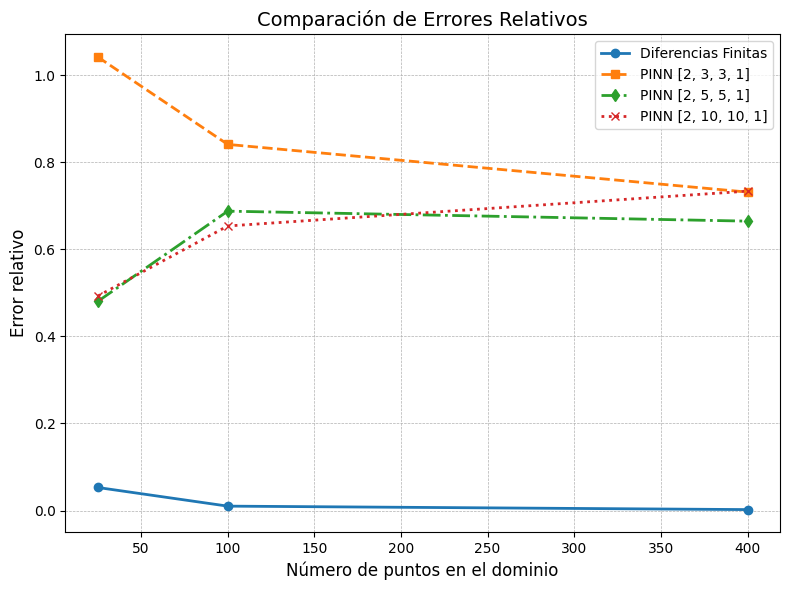

In [25]:
# Puntos de grilla
x = [25, 100, 400]

# Crear el gráfico
plt.figure(figsize=(8, 6))
plt.plot(x, conv_DF, 'o-', label='Diferencias Finitas', linewidth=2)
plt.plot(x, conv_pinn_2331, 's--', label='PINN [2, 3, 3, 1]', linewidth=2)
plt.plot(x, conv_pinn_2551, 'd-.', label='PINN [2, 5, 5, 1]', linewidth=2)
plt.plot(x, conv_pinn_210101, 'x:', label='PINN [2, 10, 10, 1]', linewidth=2)

# Personalización del gráfico
plt.xlabel('Número de puntos en el dominio', fontsize=12)
plt.ylabel('Error relativo', fontsize=12)
plt.title('Comparación de Errores Relativos', fontsize=14)
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

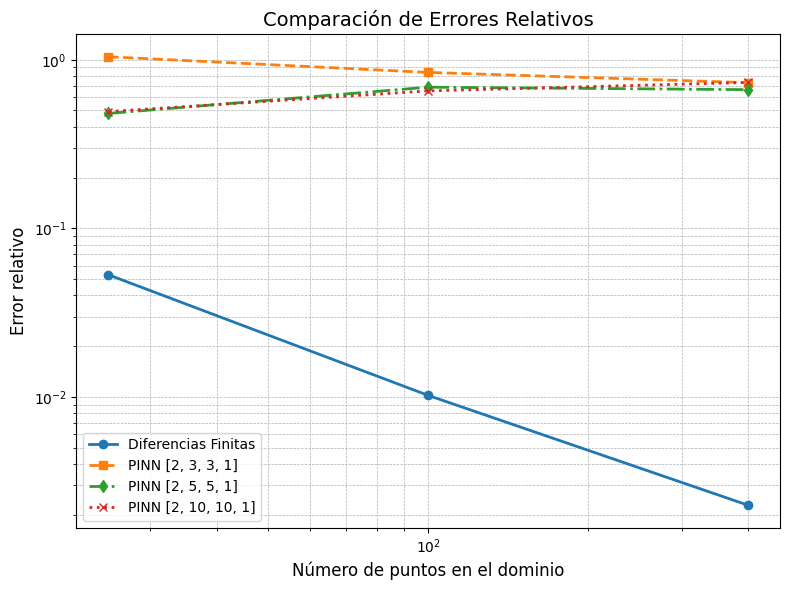

In [26]:
# Puntos de grilla
x = [25, 100, 400]

# Crear el gráfico
plt.figure(figsize=(8, 6))
plt.plot(x, conv_DF, 'o-', label='Diferencias Finitas', linewidth=2)
plt.plot(x, conv_pinn_2331, 's--', label='PINN [2, 3, 3, 1]', linewidth=2)
plt.plot(x, conv_pinn_2551, 'd-.', label='PINN [2, 5, 5, 1]', linewidth=2)
plt.plot(x, conv_pinn_210101, 'x:', label='PINN [2, 10, 10, 1]', linewidth=2)

# Personalización del gráfico
plt.xscale('log')  # Escala logarítmica en el eje x
plt.yscale('log')  # Escala logarítmica en el eje y (si aplica)
plt.xlabel('Número de puntos en el dominio', fontsize=12)
plt.ylabel('Error relativo', fontsize=12)
plt.title('Comparación de Errores Relativos', fontsize=14)
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.tight_layout()

# Mostrar el gráfico
plt.show()